In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet
import time

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 22,   
    'ytick.labelsize': 22,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [2]:
df = pd.read_csv('navitoclax.csv')
df

,Unnamed: 0,cell_line,COSMIC_ID,drug,log10_dose,viability
0,1,22RV1,924100,Navitoclax,-2.6987,0.996820
1,2,22RV1,924100,Navitoclax,-2.3008,0.927539
2,3,22RV1,924100,Navitoclax,-2.1988,1.022289
3,4,22RV1,924100,Navitoclax,-1.9998,1.038805
4,5,22RV1,924100,Navitoclax,-1.8008,0.923463
...,...,...,...,...,...,...
17666,17667,no-11,908450,Navitoclax,-1.6988,0.906616
17667,17668,no-11,908450,Navitoclax,-1.1989,0.961543
17668,17669,no-11,908450,Navitoclax,-0.6989,0.896100
17669,17670,no-11,908450,Navitoclax,-0.1989,0.848893


In [14]:
def preprocess_data(df, cell_lines):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

list_cell_lines = ['P12-ICHIKAWA', 'ARH-77']
x, Y = preprocess_data(df, list_cell_lines)

In [15]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.0
init_noise_var = np.array([0.005]*n_outputs) 

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=robust_init_A)
mogp.fit(x, Y)
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.7, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

In [16]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 2
# init_noise_var = np.array([0.005]*n_outputs)
epsilon = 0.2

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)

# Instantiate and train
morcgp = MORCGP(mean=prior_mean, length_scale=init_length_scale, noise_var=mogp.noise, A=robust_init_A)
morcgp.fit(x, Y, epsilons=np.array([epsilon]*2))
init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
x_test = np.linspace(-2.7, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

Optimized length_scale: 1.9820
Optimized noise_var: [0.01328679 0.00644499]
Optimized A: [[21.85210945  4.69570272]
 [18.73449946  4.07480428]]
Optimized B: 
[[499.56431154 428.52240231]
 [428.52240231 367.5855    ]]


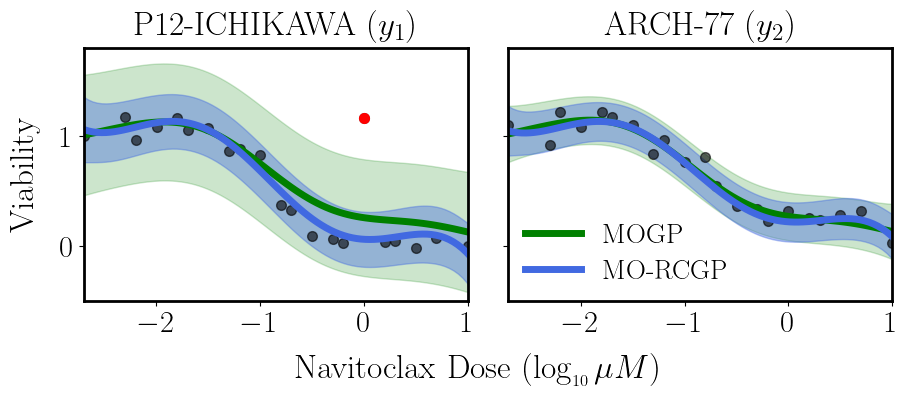

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(n_outputs):
    # Plotting data and predictions
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=7)
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_mogp[:, i] - 2*std_mogp[:, i],
                        mu_mogp[:, i] + 2*std_mogp[:, i],
                        color='green', alpha=0.2)
    
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MO-RCGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_morcgp[:, i] - 2*std_morcgp[:, i],
                        mu_morcgp[:, i] + 2*std_morcgp[:, i],
                        color='royalblue', alpha=0.4)

    # Axes limits
    axs[i].set_ylim([-0.5, 1.8])
    axs[i].set_xlim([x[0], x[-1]])

    # Titles and labels
    if i == 0:
        axs[i].set_title(r"P12-ICHIKAWA ($y_1$)", fontsize=24, pad=10)
        axs[i].set_ylabel("Viability", fontsize=24, labelpad=15)
    elif i == 1:
        axs[i].set_title(r"ARCH-77 ($y_2$)", fontsize=24, pad=10)
        axs[i].set_yticklabels([])
        axs[i].legend(loc='lower left', fontsize=20, frameon=False, borderpad=0.1, labelspacing=0.4)

    # **Thick borders (spines)**
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # change '3' to any thickness you want

# X-axis label
fig.text(0.55, -0.01, r'Navitoclax Dose $(\log_{\scriptscriptstyle 10}{\mu M})$', ha='center', fontsize=24)
axs[0].plot(x[15, 0], Y[15, 0], 'o', color='red', alpha=1, markersize=7)
plt.tight_layout()
plt.show()
# fig.savefig("./navitoclax.pdf", format='pdf', bbox_inches='tight')

In [28]:
x_test.shape
mu_mogp[:,0].shape

(100,)

In [40]:
def get_interval_IC50(mu, std):
    # Compute the lower and upper bounds of the 95% CI
    lower = mu[:, 1] - 1.96 * std[:, 1]
    upper = mu[:, 1] + 1.96 * std[:, 1]

    # Find indices where 0.5 is inside the CI
    indices = np.where((0.5 >= lower) & (0.5 <= upper))[0]

    # Optional: get the corresponding x_test values
    x_values = x_test[indices, 0]

    print("Indices:", indices)
    print("x_test values:", x_values)

get_interval_IC50(mu_mogp, std_mogp)

Indices: [42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
x_test values: [-0.91818182 -0.87575758 -0.83333333 -0.79090909 -0.74848485 -0.70606061
 -0.66363636 -0.62121212 -0.57878788 -0.53636364 -0.49393939 -0.45151515
 -0.40909091 -0.36666667 -0.32424242 -0.28181818 -0.23939394 -0.1969697
 -0.15454545 -0.11212121]
